# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras
import tensorflow as tf

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
from keras.utils import np_utils

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = np_utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [13]:
## 超參數設定
LEARNING_RATE = [0.1, 0.01, 0.001, 0.0001, 0.00001]
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.9

In [14]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with LR = 0.100000
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
196/196 [==============================] - 2s 7ms/step - loss: 273.3937 - accuracy: 0.0998 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 2/10
196/196 [==============================] - 1s 6ms/step - loss: 2.3039 - accuracy: 0.0990 - val_loss: 2.3040 - val_accuracy: 0.1000
Epoch 3/10
196/196 [==============================] - 1s 6ms/step - loss: 2.3044 - accuracy: 0.0985 - val_loss: 2.3045 - val_accuracy: 0.1000
Epoch 4/10
196/196 [==============================] - 1s 6ms/step - loss: 2.3047 - accuracy: 0.0982 - val_loss: 2.3044 - val_accuracy: 0.1000
Epoch 5/10
196/196 [==============================] - 1s 6ms/step - loss: 2.3053 - accuracy: 0.0978 - val_loss: 2.3050 - val_accuracy: 0.1000
Epoch 6/10
196/196 [==============================] - 1s 6ms/step - loss: 2.3052 - accuracy: 0.0985 - val_loss: 2.3060 - val_accuracy: 0.1000
Epoch 7/10
196/196 [==============================] - 1s 6ms/step - loss: 2.3064 - accuracy: 0.0976 - val_loss: 2.3065 - val_accuracy: 0.1000
Epoc

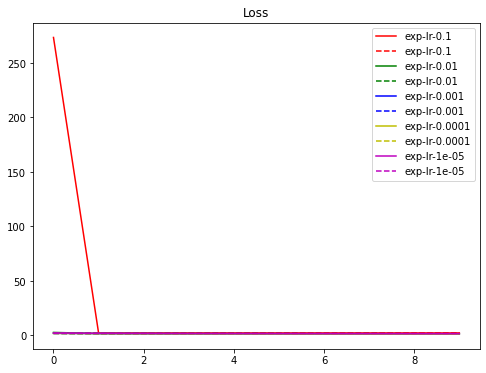

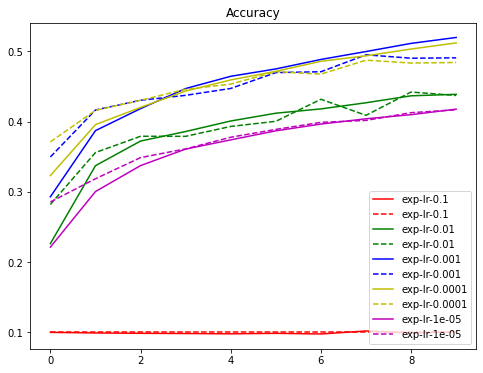

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [17]:
#AdaGrad Adagrad

results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = tf.keras.optimizers.Adagrad(lr=lr)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with LR = 0.100000
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/10
196/196 [==============================] - 3s 11ms/step - loss: 2.2418 - accuracy: 0.1764 - val_loss: 1.9918 - val_accuracy: 0.2591
Epoch 2/10
196/196 [==============================] - 2s 8ms/step - loss: 1.9955 - accuracy: 0.2728 - val_loss: 1.9833 - val_accuracy: 0.2791
Epoch 3/10
196/196 [==============================] - 1s 6ms/step - loss: 1.8635 - accuracy: 0.3266 - val_loss: 1.9003 - val_accuracy: 0.3100
Epoch 4/10
196/196 [==============================] - 1s 6ms/step - loss: 1.8126 - accuracy: 0.3451 - val_loss: 1.7680 - val_accuracy: 0.3646
Epoch 5/10
196/196 [==============================] - 1s 6ms/step - loss: 1.7274 - accuracy: 0.3780 - val_loss: 1.7343 - val_accuracy: 0.3814
Epoch 6/10
196/196 [==============================] - 1s 6ms/step - loss: 1.6829 - accuracy: 0.3977 - val_loss: 1.7924 - val_accuracy: 0.3657
Epoch 7/10
196/196 [==============================] - 1s 6ms/step - loss: 1.6471 - accuracy: 0.4091 - val_loss: 1.7401 - val_accuracy: 0.3749
Epoch

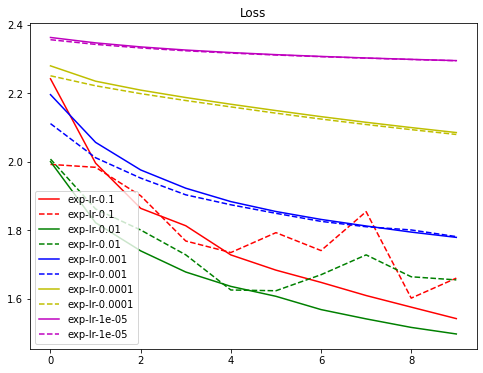

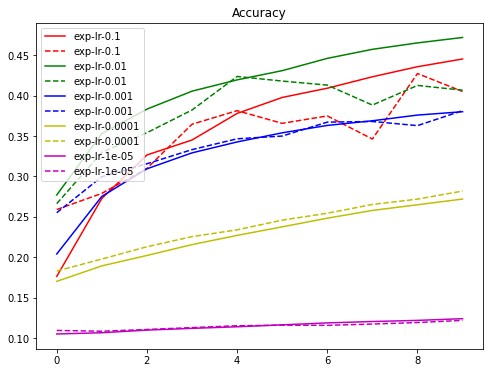

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [ ]:
def build_mlp():
    """
    Build your own model
    """
    
    return model

In [ ]:
## 超參數設定
"""
Set your required experiment parameters
"""



In [ ]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""